In [1]:
#1. More algorithm benchmarks
# BV, Hidden shift, Add, SquareRoot, Supremacy
#2. Large topologies and hypercube
#3. IBM vs Surface

#TODO: define larger backends, and hypercube
#TODO: collect list of functions to test
#TODO: rewrite transpiler classes to use dictionary instead of list

In [2]:
import sys
sys.path.append("..")
import logging
#logging.basicConfig(level=0)

In [3]:
"""Define circuits to test"""
from supermarq.benchmarks import *
from supermarq.features import cirq_to_qiskit

class CircuitTranspilerBenchmark():
    #TODO: circuit_lambda could take multiple params if desired
    def __init__(self, circuit_lambda, q_range, label):
        self.circuit_lambda = circuit_lambda
        self.q_range = q_range
        self.label = label

circuits = {}
q_range = range(4,10)
depth = 10

#Random
from qiskit.circuit.random import random_circuit
random_lambda = lambda q: random_circuit(q, depth, measure=False, max_operands=2)
label = "Randomized QC"
circuits[label] = (CircuitTranspilerBenchmark(random_lambda, q_range, label=label))

#Quantum Volume
from qiskit.circuit.library import QuantumVolume
qv_lambda = lambda q: QuantumVolume(q, depth)
label = "Quantum Volume"
circuits[label] = (CircuitTranspilerBenchmark(qv_lambda, q_range, label=label))

#QFT
from qiskit.circuit.library.basis_change import QFT
qft_lambda = lambda q: QFT(q)
label = "QFT"
circuits[label] = (CircuitTranspilerBenchmark(qft_lambda, q_range, label=label))

#Inverse QFT
inverse_qft_lambda = lambda q: QFT(q, inverse=True)
label = "IQFT"
circuits[label] = (CircuitTranspilerBenchmark(inverse_qft_lambda, q_range, label=label))

#QAOA, takes a long time to generate - consider capping max size before 20
qaoa_lambda = lambda q: cirq_to_qiskit(QAOAFermionicSwapProxy(q).circuit())
label = "QAOA Fermionic Swap"
circuits[label] = (CircuitTranspilerBenchmark(qaoa_lambda, q_range, label=label))

#QAOA vanilla
qaoa_vanilla_lambda = lambda q: cirq_to_qiskit(QAOAVanillaProxy(q).circuit())
label = "QAOA Vanilla"
circuits[label] = (CircuitTranspilerBenchmark(qaoa_vanilla_lambda, q_range, label=label))

#VQE - very slow to generate
vqe_lambda = lambda q: cirq_to_qiskit(VQEProxy(q, 4).circuit()[0])
label = "VQE"
circuits[label] = (CircuitTranspilerBenchmark(vqe_lambda, q_range, label=label))

#Simulation 
hamiltonian_lambda = lambda q: cirq_to_qiskit(HamiltonianSimulation(q, 1/depth, 1).circuit())
label = "TIM Hamiltonian"
circuits[label] = (CircuitTranspilerBenchmark(hamiltonian_lambda, q_range, label=label))

#GHZ
ghz_lambda = lambda q: cirq_to_qiskit(GHZ(q).circuit())
label = "GHZ"
circuits[label] = (CircuitTranspilerBenchmark(ghz_lambda, q_range, label=label))

In [6]:
"""Define backends to test"""
from mock_backend import *
from decomp_analysis.pass_manager_v2 import level_0_pass_manager

class BackendTranspilerBenchmark():
    def __init__(self, backend, pm, label):
        self.backend = backend
        self.pass_manager = pm
        self.label = label
        self.times = []

backends = {}

backend_hatlab = FakeHatlab(router_as_qubits=True)
pm_hatlab = level_0_pass_manager(backend_hatlab, basis_gate="riswap")
label = "Hatlab-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_hatlab, pm_hatlab, label)

backend_lattice = FakeSurfaceCode(twoqubitgate="riswap")
pm_lattice = level_0_pass_manager(backend_lattice, basis_gate="riswap")
label = "Lattice-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_lattice, pm_lattice, label)

backend_lattice = FakeSurfaceCode(twoqubitgate="cx")
pm_lattice = level_0_pass_manager(backend_lattice, basis_gate="cx")
label = "Lattice-CX"
backends[label] = BackendTranspilerBenchmark(backend_lattice, pm_lattice, label)

"""Large Backends"""
#Large Lattice
backend_lattice = FakeSurfaceCode(twoqubitgate="cx", qubit_size=81, row_length=9)
pm_lattice = level_0_pass_manager(backend_lattice, basis_gate="cx")
label = "Lattice-Large-CX"
backends[label] = BackendTranspilerBenchmark(backend_lattice, pm_lattice, label)

backend_lattice = FakeSurfaceCode(twoqubitgate="riswap", qubit_size=81, row_length=9)
pm_lattice = level_0_pass_manager(backend_lattice, basis_gate="riswap")
label = "Lattice-Large-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_lattice, pm_lattice, label)

#Large Hypercubes
backend_hypercube = FakeHyperCubeV2(6, twoqubitgate="cx")
pm_hypercube = level_0_pass_manager(backend_hypercube, basis_gate="cx")
label = "Hypercube-Large-CX"
backends[label] = BackendTranspilerBenchmark(backend_hypercube, pm_hypercube, label)

backend_hypercube = FakeHyperCubeV2(6, twoqubitgate="riswap")
pm_hypercube = level_0_pass_manager(backend_hypercube, basis_gate="riswap")
label = "Hypercube-Large-Riswap"
backends[label] = BackendTranspilerBenchmark(backend_hypercube, pm_hypercube, label)

#Large Hatlab
backend_hatlab = FakeHatlab(dimension=2, router_as_qubits=True)
pm_hatlab = level_0_pass_manager(backend_hatlab, basis_gate="riswap")
label = "Hatlab-Riswap-Large"
backends[label] = BackendTranspilerBenchmark(backend_hatlab, pm_hatlab, label)

large_backends = [backend[1] for backend in backends.items() if "Large" in backend[0]]

This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output
This backend's operations: cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially cr

In [ ]:
#make a plot :)
import matplotlib.pyplot as plt

def benchmark(backends, circuit_generator, q_range=None):
    #override qrange if provided
    if q_range is None:
        q_range = circuit_generator.q_range
        
    #reset time arrays
    for backend in backends:
        backend.times = []
        
    for q in q_range:
        #create new variable sized lambda circuit
        qc = circuit_generator.circuit_lambda(q)

        for backend in backends:
            #logging.info(f"Transpiler qc{q} for {backend.label}")
            print(f"Transpiler qc{q} for {backend.label}")
            backend.pass_manager.run(qc)
            backend.times.append(backend.pass_manager.property_set["duration_longest_path_length"])

    for backend in backends:
        plt.plot(q_range, backend.times, '-o', label=backend.label)

    plt.xlabel(circuit_generator.label)
    plt.ylabel("circuit duration")
    plt.legend()
    plt.savefig(f"images/large_{circuit_generator.label}")

In [ ]:
circuit_gen = circuits["TIM Hamiltonian"]
benchmark(backends=large_backends, circuit_generator=circuit_gen, q_range=[4,5,6])

In [8]:
circuit_gen = circuits["TIM Hamiltonian"]
benchmark(backends=large_backends, circuit_generator=circuit_gen, q_range=[10, 20, 30, 40, 50])

Transpiler qc10 for Lattice-Large-CX
Transpiler qc10 for Lattice-Large-Riswap
Transpiler qc10 for Hypercube-Large-CX
Transpiler qc10 for Hypercube-Large-Riswap
Transpiler qc10 for Hatlab-Riswap-Large
Transpiler qc20 for Lattice-Large-CX
Transpiler qc20 for Lattice-Large-Riswap
Transpiler qc20 for Hypercube-Large-CX
Transpiler qc20 for Hypercube-Large-Riswap
Transpiler qc20 for Hatlab-Riswap-Large
Transpiler qc30 for Lattice-Large-CX
Transpiler qc30 for Lattice-Large-Riswap
Transpiler qc30 for Hypercube-Large-CX
Transpiler qc30 for Hypercube-Large-Riswap
Transpiler qc30 for Hatlab-Riswap-Large
Transpiler qc40 for Lattice-Large-CX


Transpiler qc10 for Lattice-Large-CX
Transpiler qc10 for Hypercube-Large-CX
Transpiler qc20 for Lattice-Large-CX
Transpiler qc20 for Hypercube-Large-CX
Transpiler qc30 for Lattice-Large-CX
Transpiler qc30 for Hypercube-Large-CX
Transpiler qc40 for Lattice-Large-CX
Transpiler qc40 for Hypercube-Large-CX
Transpiler qc50 for Lattice-Large-CX
Transpiler qc50 for Hypercube-Large-CX


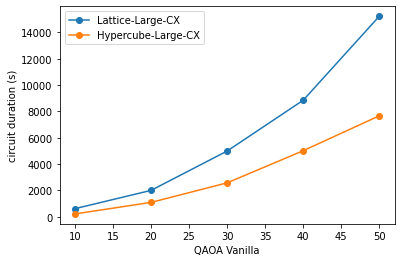

In [ ]:
circuit_gen = circuits["QAOA Vanilla"]
benchmark(backends=large_backends, circuit_generator=circuit_gen, q_range=[10, 20, 30, 40, 50])

Transpiler qc10 for Lattice-Large-CX
Transpiler qc10 for Hypercube-Large-CX
Transpiler qc20 for Lattice-Large-CX
Transpiler qc20 for Hypercube-Large-CX
Transpiler qc30 for Lattice-Large-CX
Transpiler qc30 for Hypercube-Large-CX
Transpiler qc40 for Lattice-Large-CX
Transpiler qc40 for Hypercube-Large-CX
Transpiler qc50 for Lattice-Large-CX
Transpiler qc50 for Hypercube-Large-CX


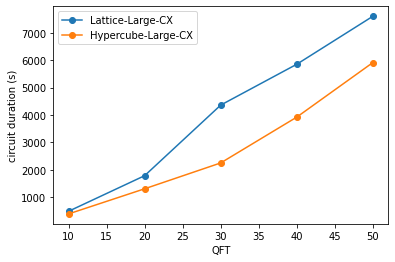

In [ ]:
circuit_gen = circuits["QFT"]
benchmark(backends=large_backends, circuit_generator=circuit_gen, q_range=[10, 20, 30, 40, 50])

Transpiler qc10 for Lattice-Large-CX
Transpiler qc10 for Hypercube-Large-CX
Transpiler qc20 for Lattice-Large-CX
Transpiler qc20 for Hypercube-Large-CX
Transpiler qc30 for Lattice-Large-CX
Transpiler qc30 for Hypercube-Large-CX
Transpiler qc40 for Lattice-Large-CX
Transpiler qc40 for Hypercube-Large-CX
Transpiler qc50 for Lattice-Large-CX
Transpiler qc50 for Hypercube-Large-CX


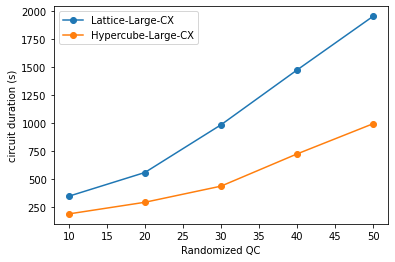

In [ ]:
circuit_gen = circuits["Randomized QC"]
benchmark(backends=large_backends, circuit_generator=circuit_gen, q_range=[10, 20, 30, 40, 50])